# Análisis de Ventas

## Desarrollado por Julian Quimbayo

### Se desea predecir las ventas futuras apoyados en la siguiente data que se comparte a continuación:

### PASO 1: Importación de librerías

In [49]:
###Cargue de Librerías Básicas
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

### PASO 2: Cargue de la data y refinamiento de tipos de datos

In [6]:
##Importación de todas las fuentes de datos y reconversión de tipos de datos.
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PruebaAltipal/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 'item_id': 'int32'})

item_categorias = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PruebaAltipal/item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})

items = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PruebaAltipal/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})

tiendas = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PruebaAltipal/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})

ventas = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PruebaAltipal/sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

In [7]:
##Join entre ventas que se une con items en item_id, ventas con tiendas que se unen en shop_id y 
##ventas con item_categorias que se unen en item_category_id
train = ventas.join(items, on='item_id', rsuffix='_').join(tiendas, on='shop_id', rsuffix='_').join(item_categorias, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,2013-03-01,0,25,2552,899.00,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,2013-05-01,0,25,2552,899.00,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,2013-06-01,0,25,2554,1709.05,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства


### PASO 3: Análisis Exploratorio Descriptivo (EDA)

In [8]:
#Análisis exploratorio inicial - se encuentran 2935849 de observaciones por 10 columnas de trabajo sin valores de tipo NAN.
def inicio_EDA(df):
    if isinstance(df, pd.DataFrame):
        total_na = df.isna().sum().sum()
        print("Dimensiones : %d filas, %d columnas" % (df.shape[0], df.shape[1]))
        print("Total Valores NA : %d " % (total_na))
        print("%38s %10s     %10s %10s" % ("Nombre Columna", "Tipo de Dato", "#Distintos", "Valores NA"))
        col_name = df.columns
        dtyp = df.dtypes
        uniq = df.nunique()
        na_val = df.isna().sum()
        for i in range(len(df.columns)):
            print("%38s %10s   %10s %10s" % (col_name[i], dtyp[i], uniq[i], na_val[i]))
        
    else:
        print("Se esperaba dataframe %15s" % (type(df)))

       
inicio_EDA(train)

Dimensiones : 2935849 filas, 10 columnas
Total Valores NA : 0 
                        Nombre Columna Tipo de Dato     #Distintos Valores NA
                                  date datetime64[ns]         1034          0
                        date_block_num      int32           34          0
                               shop_id      int32           60          0
                               item_id      int32        21807          0
                            item_price    float32        19992          0
                          item_cnt_day      int32          198          0
                             item_name     object        21807          0
                      item_category_id      int32           84          0
                             shop_name     object           60          0
                    item_category_name     object           84          0


In [9]:
##Aplicando la estadística inicial de tendencia central vemos que semeja una distribución interesante para revisar
##posteriormente en gráficas.
train.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.00,14.57,9.42,0.00,7.00,14.00,23.00,33.00
shop_id,2935849.00,33.00,16.23,0.00,22.00,31.00,47.00,59.00
item_id,2935849.00,10197.23,6324.30,0.00,4476.00,9343.00,15684.00,22169.00
item_price,2935849.00,890.62,1726.44,-1.00,249.00,399.00,999.00,307980.00
item_cnt_day,2935849.00,1.24,2.62,-22.00,1.00,1.00,1.00,2169.00
item_category_id,2935849.00,40.00,17.10,0.00,28.00,40.00,55.00,83.00


In [10]:
###Periodo de las mediciones
print('Fecha mínima para el set de entrenamiento: %s' % train['date'].min().date())
print('Fecha Máxima para el set de entrenamiento: %s' % train['date'].max().date())

Fecha mínima para el set de entrenamiento: 2013-01-01
Fecha Máxima para el set de entrenamiento: 2015-12-10


In [11]:
##Reducción de dimensionalidad cruzando los datos con los existentes en test
##Por medio de Shop_id e item_id
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()

new_train = train[train['shop_id'].isin(test_shop_ids)]

new_train = new_train[new_train['item_id'].isin(test_item_ids)]

In [12]:
##Comparativa antes y después de la reducción de dimensiones por medio de Id's
print('Tamaño Inicial de Dataframe:', train.shape[0])
print('Tamaño Final de Dataframe:', new_train.shape[0])

Tamaño Inicial de Dataframe: 2935849
Tamaño Final de Dataframe: 1224439


In [13]:
##Se modificará solo los items mayores a cero
train = train.query('item_price > 0')

train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,2013-03-01,0,25,2552,899.00,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,2013-05-01,0,25,2552,899.00,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,2013-06-01,0,25,2554,1709.05,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства


In [14]:
##Se determinan las variables más importantes para trabajar
train_mensual = new_train[['date', 'date_block_num', 
                           'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]

In [15]:
##Se agrupa por mes, en este caso date_block_num y se agregan las demás características
train_mensual = train_mensual.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)

train_mensual = train_mensual.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})

train_mensual.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [16]:
##Se procede a crear un dataframe con todas las combinaciones posibles
##Utilizando el shop_id, item_id para posteriormente fusionar con el dataframe train_mensual
shop_ids = train_mensual['shop_id'].unique()
item_ids = train_mensual['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
data_complementario = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

In [17]:
##Se unen los dos dataframes para complementar la información inicial
train_mensual = pd.merge(data_complementario, train_mensual, on=['date_block_num','shop_id','item_id'], how='left')
train_mensual.fillna(0, inplace=True)

In [18]:
###Se realiza una nueva revisión
inicio_EDA(train_mensual)

Dimensiones : 6734448 filas, 9 columnas
Total Valores NA : 0 
                        Nombre Columna Tipo de Dato     #Distintos Valores NA
                        date_block_num      int64           34          0
                               shop_id      int64           42          0
                               item_id      int64         4716          0
                      item_category_id    float64           61          0
                            item_price    float32        26489          0
                       mean_item_price    float32        22785          0
                              item_cnt    float64          387          0
                         mean_item_cnt    float64         1435          0
                          transactions    float64           32          0


In [19]:
train_mensual.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6734448.00,16.50,9.81,0.00,8.00,16.50,25.00,33.00
shop_id,6734448.00,31.64,17.56,2.00,16.00,34.50,47.00,59.00
item_id,6734448.00,11041.89,6210.74,30.00,5385.25,11265.50,16068.25,22167.00
item_category_id,6734448.00,3.79,13.21,0.00,0.00,0.00,0.00,83.00
item_price,6734448.00,187.35,2171.80,0.00,0.00,0.00,0.00,515573.59
mean_item_price,6734448.00,81.13,531.16,0.00,0.00,0.00,0.00,42990.00
item_cnt,6734448.00,0.24,3.46,-4.00,0.00,0.00,0.00,2253.00
mean_item_cnt,6734448.00,0.10,0.61,-2.00,0.00,0.00,0.00,1000.00
transactions,6734448.00,0.18,0.90,0.00,0.00,0.00,0.00,31.00


In [20]:
##Se procede a extraer el año y mes del dataframe
train_mensual['year'] = train_mensual['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_mensual['month'] = train_mensual['date_block_num'].apply(lambda x: (x % 12))

### PASO 4: Gráficas Relevantes

In [21]:
gp_mes_mean = train_mensual.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_mes_sum = train_mensual.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_categoria_mean = train_mensual.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_categoria_sum = train_mensual.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_tienda_mean = train_mensual.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_tienda_sum = train_mensual.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

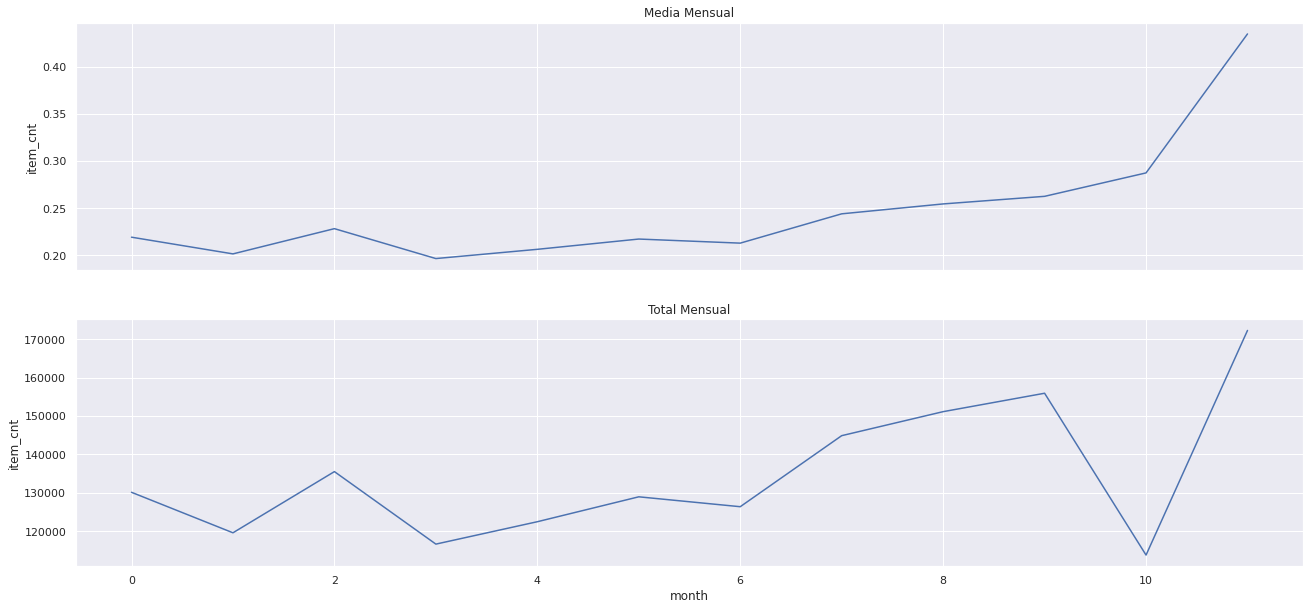

In [22]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_mes_mean, ax=axes[0]).set_title("Media Mensual")
sns.lineplot(x="month", y="item_cnt", data=gp_mes_sum, ax=axes[1]).set_title("Total Mensual")
plt.show()

#Al final del periodo seleccionado se aumentan las ventas por encima de la media.

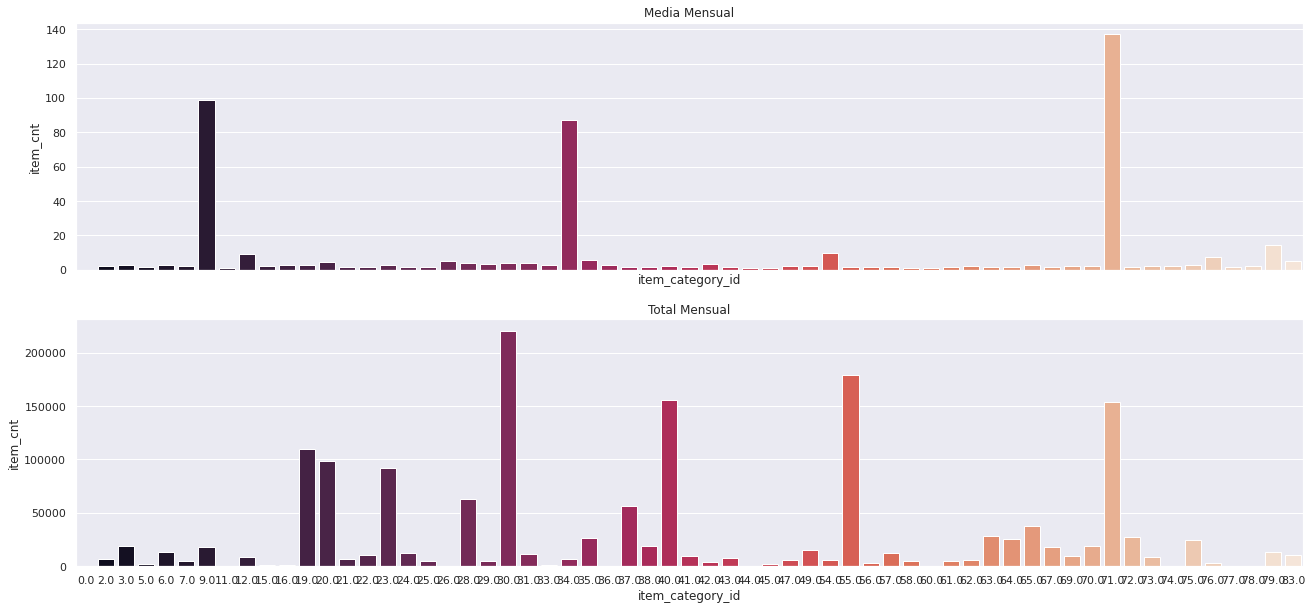

In [23]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_categoria_mean, ax=axes[0], palette="rocket").set_title("Media Mensual")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_categoria_sum, ax=axes[1], palette="rocket").set_title("Total Mensual")
plt.show()
##Aparentemente solo algunas categorías presentan ventas superiores.

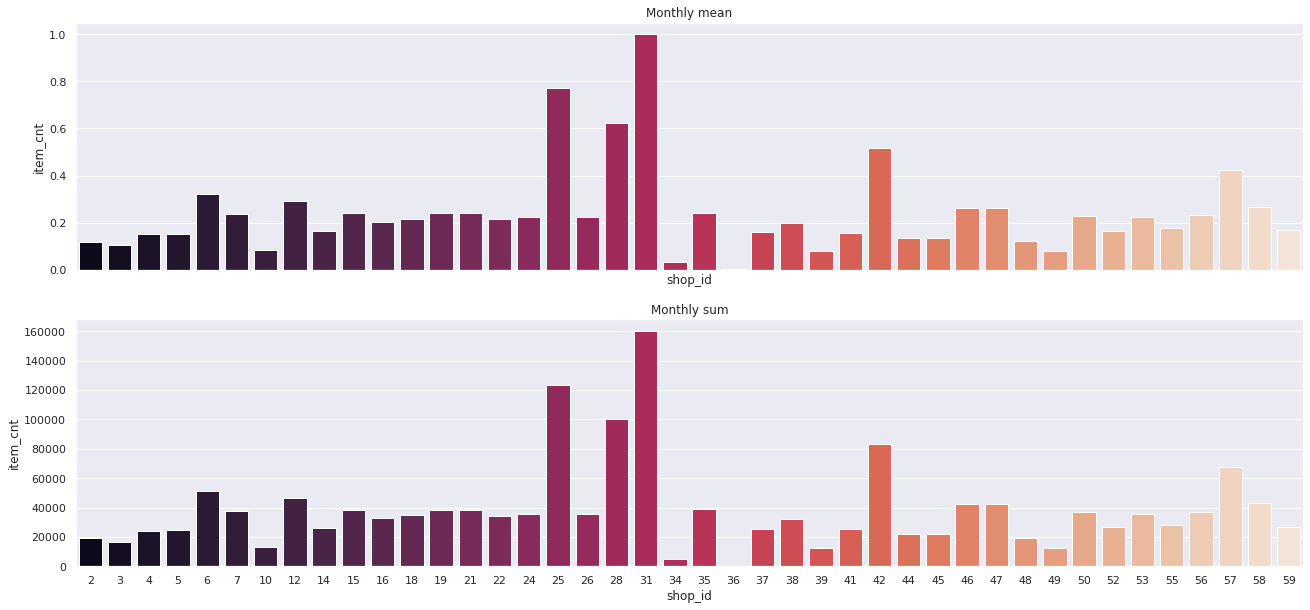

In [24]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_tienda_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_tienda_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()
##Se evidencian alrededor de 3 tiendas que superan la cantidad vendida durante el periodo 2013 al 2015.

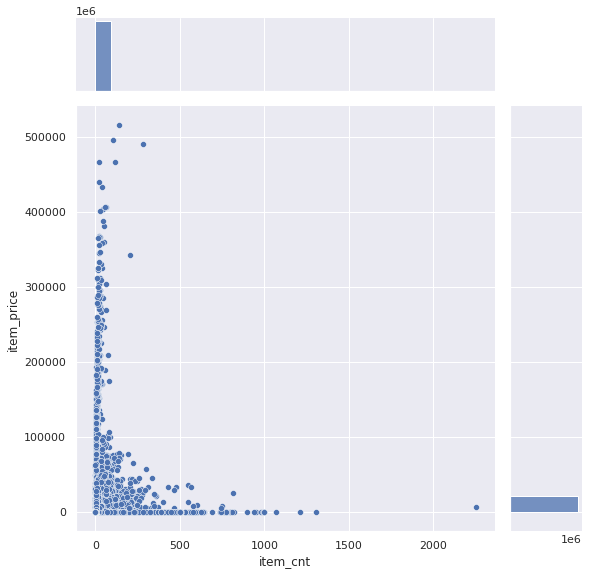

In [25]:
##Verificando Outliers
sns.jointplot(x="item_cnt", y="item_price", data=train_mensual, height=8)
plt.show()

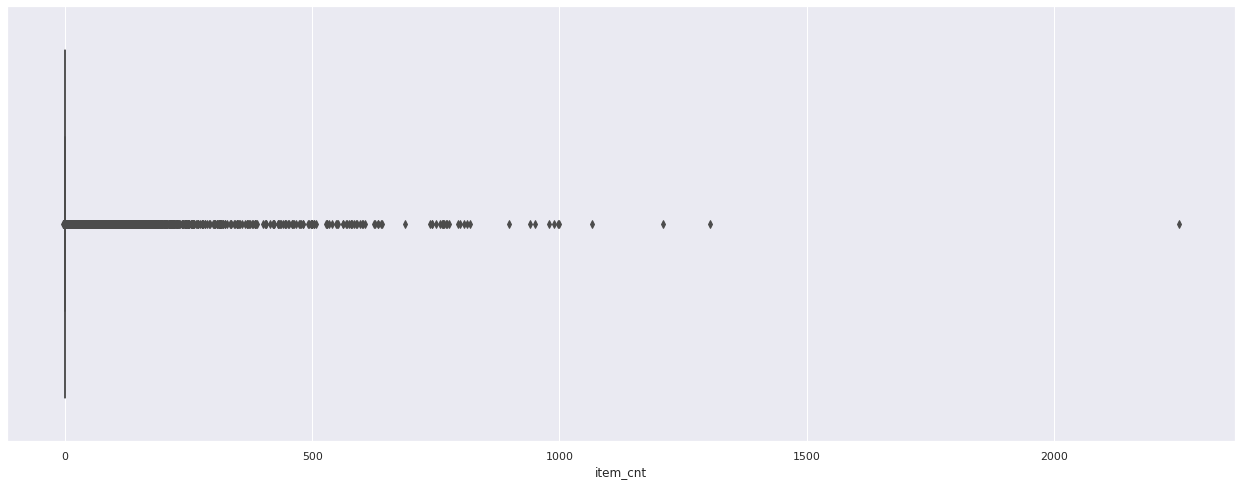

In [26]:
plt.subplots(figsize=(22, 8))
sns.boxplot(train_mensual['item_cnt'])
plt.show()

##Tomando el límite anterior, se procede a reducir la data por medio 
## de una relación item_cnt>=0 & item_cnt <=20 & item_price < 400000 remueve outliers si cumple

In [27]:
train_mensual = train_mensual.query('item_cnt >= 0 and item_cnt <= 20 and item_price < 400000')

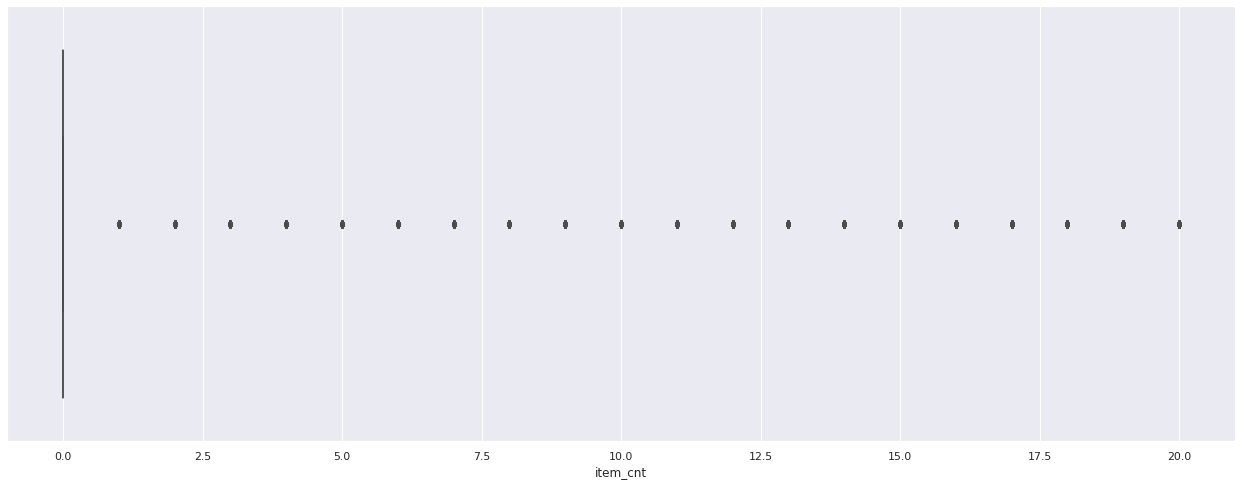

In [28]:
plt.subplots(figsize=(22, 8))
sns.boxplot(train_mensual['item_cnt'])
plt.show()

##Se evidencia la reducción de ruido en los datos.

### PASO 5: Ingeniería de Variables

In [29]:
##Paso 5.1 Crear la etiqueta donde se va a guardar el conteo mes a mes
train_mensual['item_cnt_month'] = train_mensual.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

## Paso 5.2 Unidad de precio por cada elemento (Valor unitario) es la división entre precio del item y el conteo del mismo
train_mensual['item_price_unit'] = train_mensual['item_price'] // train_mensual['item_cnt']
##Si hay datos NAN se rellena con cero.
train_mensual['item_price_unit'].fillna(0, inplace=True)

## Paso 5.3 Agrupaciones por fecha y el id respetando los valores minimos y maximos del precio es decir en un rango
gp_item_precio = train_mensual.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})

## Paso 5.4 Damos nombres a las columnas
gp_item_precio.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

## Paso 5.5 Unimos al data frame original con un merge por item_id usando un leftjoin es decir
##todo va para train_mensual
train_mensual = pd.merge(train_mensual, gp_item_precio, on='item_id', how='left')

##Paso 5.6 el incremento del precio se da por el historial del movimiento del precio menos el valor actual.
train_mensual['price_increase'] = train_mensual['item_price'] - train_mensual['hist_min_item_price']
train_mensual['price_decrease'] = train_mensual['hist_max_item_price'] - train_mensual['item_price']

##Paso 5.7 por medio de funciones lambda se crea la ventana de observacion de tres periodos
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']



In [30]:
train_mensual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6728118 entries, 0 to 6728117
Data columns (total 17 columns):
 #   Column               Dtype  
---  ------               -----  
 0   date_block_num       int64  
 1   shop_id              int64  
 2   item_id              int64  
 3   item_category_id     float64
 4   item_price           float32
 5   mean_item_price      float32
 6   item_cnt             float64
 7   mean_item_cnt        float64
 8   transactions         float64
 9   year                 int64  
 10  month                int64  
 11  item_cnt_month       float64
 12  item_price_unit      float64
 13  hist_min_item_price  float32
 14  hist_max_item_price  float32
 15  price_increase       float32
 16  price_decrease       float32
dtypes: float32(6), float64(6), int64(5)
memory usage: 770.0 MB


In [31]:
for i in range(len(function_list)):
    train_mensual[('item_cnt_%s' % function_name[i])] = train_mensual.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

train_mensual['item_cnt_std'].fillna(0, inplace=True)

In [32]:
lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_mensual[ft_name] = train_mensual.sort_values('date_block_num').groupby(['shop_id', 'item_category_id',
                                                                                  'item_id'])['item_cnt'].shift(lag)
    
    train_mensual[ft_name].fillna(0, inplace=True)
    
train_mensual['item_trend'] = train_mensual['item_cnt']

In [33]:
for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_mensual['item_trend'] -= train_mensual[ft_name]

train_mensual['item_trend'] /= len(lag_list) + 1

In [36]:
train_set = train_mensual.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_set = train_mensual.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = train_mensual.query('date_block_num == 33').copy()

train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

print('Datos de Entrenamiento:', train_set.shape[0])
print('Datos de Validación:', validation_set.shape[0])
print('Datos de Testeo:', test_set.shape[0])


Datos de Entrenamiento: 4946785
Datos de Validación: 989412
Datos de Testeo: 197879


In [37]:
# Agrupamiento de datos por media
gp_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)

gp_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)

gp_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)

gp_year_mean = train_set.groupby(['year']).agg({'item_cnt_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)

gp_month_mean = train_set.groupby(['month']).agg({'item_cnt_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)


train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')

validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')

**PASO 6: Train, test & Validation**

In [38]:
# Entrenamiento y validación
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_month'].astype(int)

In [40]:
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

In [41]:
sets = [X_train, X_validation, X_test]

for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
            
# Relleno de datos nulos con la media
X_test.fillna(X_test.mean(), inplace=True)

In [42]:
# Eliminación de valores innecesarios
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

In [43]:
# Variables seleccionadas random Forest
rf_features = ['shop_id', 'item_id', 'item_cnt', 'transactions', 'year',
               'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
               'shop_mean', 'item_mean', 'item_trend', 'mean_item_cnt']
rf_train = X_train[rf_features]
rf_val = X_validation[rf_features]
rf_test = X_test[rf_features]

In [44]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, Y_train)

RandomForestRegressor(max_depth=7, n_estimators=50, n_jobs=-1, random_state=0)

In [45]:
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)

**PASO 6: Métricas**

In [54]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validacion rmse:', np.sqrt(mean_squared_error(Y_validation, rf_val_pred)))
print('Eficiencia del modelo:', r2_score(Y_train, rf_train_pred))

##Con datos de entrenamiento vemos una precisión media de ajuste del modelo random forest

##Con datos de validación se aleja un poco más de la precisión requerida por ende se justifica el
##43% de eficiencia del modelo. Se escogen dichas métricas debido a que son mas confiables y se
##expresan en las mismas unidades de la variable a predecir.

Train rmse: 0.6985868322226099
Validacion rmse: 0.776123635046122
Eficiencia del modelo: 0.43382474276220717
